### EDA: Trực quan hóa và phân phối điểm theo môn, tổ hợp và năm

In [15]:
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

In [ ]:
import sys
import os

# 1. Lấy đường dẫn của thư mục 'Notebook'
current_dir = os.getcwd() 

# 2. Lấy đường dẫn của thư mục Project_Root (Thư mục cha của 'Notebook' và 'Module')
# Đây là thư mục Project_Root/
project_root_dir = os.path.dirname(current_dir)

# 3. Thêm Project_Root vào sys.path
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    
print(f"Đã thêm đường dẫn gốc: {project_root_dir}")

# Lệnh import này sẽ hoạt động sau khi thêm Project_Root vào sys.path
from Module.Load_Data import DataLoader
from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis

Đã thêm đường dẫn gốc: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject


## Chọn môn học:

In [31]:
# Xây dựng Map chọn môn học
subject_map = {
    1: "toan",
    2: "ngu_van",
    3: "vat_li",
    4: "hoa_hoc",
    5: "sinh_hoc",
    6: "tin_hoc",
    7: "cn_cong_nghiep",
    8: "cn_nong_nghiep",
    9: "lich_su",
    10: "dia_li",
    11: "gdcd",
    12: "ngoai_ngu",
    13: "ma_ngoai_ngu"
}

print("=== Danh sách môn học ===")
for k, v in subject_map.items():
    print(f"{k}: {v}")

choice = int(input("\nNhập số môn bạn muốn chọn: "))

if choice in subject_map:
    print("Bạn đã chọn:", subject_map[choice])
else:
    print("❌ Không hợp lệ")


=== Danh sách môn học ===
1: toan
2: ngu_van
3: vat_li
4: hoa_hoc
5: sinh_hoc
6: tin_hoc
7: cn_cong_nghiep
8: cn_nong_nghiep
9: lich_su
10: dia_li
11: gdcd
12: ngoai_ngu
13: ma_ngoai_ngu
Bạn đã chọn: ngu_van


In [32]:
proc = DataProcessor()

# Gọi pipeline xử lý rồi lấy dữ liệu
proc.process_all()
df = proc.get_processed_data()
    
# Phân tích dữ liệu
analysis = Analysis(proc)
ChoiceSubj_df = analysis.get_arregate_by_exam_subsections(subject=subject_map[choice])
ChoiceSubj = subject_map[choice]

In [33]:
mask_2025 = df["nam_hoc"] == 2025
mask_ChoiceSubj = df[subject_map[choice]].notna()

df_2025 = df.loc[mask_2025]
so_all_2025 = df_2025.shape[0]

so_ChoiceSubj_2025 = df_2025.loc[mask_ChoiceSubj].shape[0]
# hoặc:
# so_li_2025 = (mask_2025 & mask_li).sum()

print("Tổng HS năm 2025:", so_all_2025)
print(f"HS có điểm {ChoiceSubj} năm 2025:", so_ChoiceSubj_2025)


Tổng HS năm 2025: 1153072
HS có điểm ngu_van năm 2025: 1144098


In [34]:
# Set Pivot Table để dễ nhìn
ChoiceSubj_23 = ChoiceSubj_df[ChoiceSubj_df["nam_hoc"].isin([2023])].pivot_table(
    index="nam_hoc",
    columns="diem",
    values="so_hoc_sinh",
    fill_value=0,
).squeeze()
    
ChoiceSubj_24 = ChoiceSubj_df[ChoiceSubj_df["nam_hoc"].isin([2024])].pivot_table(
    index="nam_hoc",
    columns="diem",
    values="so_hoc_sinh",
    fill_value=0,
).squeeze()
    
ChoiceSubj_25 = ChoiceSubj_df[ChoiceSubj_df["nam_hoc"] == 2025].pivot_table(
    index="nam_hoc",
    columns="diem",
    values="so_hoc_sinh",
    fill_value=0,
).squeeze()
    

In [35]:
print(ChoiceSubj_23)


diem
0.00        24.0
0.25         8.0
0.50        19.0
0.75        29.0
1.00        12.0
          ...   
9.08         3.0
9.25     12073.0
9.50      4661.0
9.75       443.0
10.00        1.0
Name: 2023, Length: 215, dtype: float64


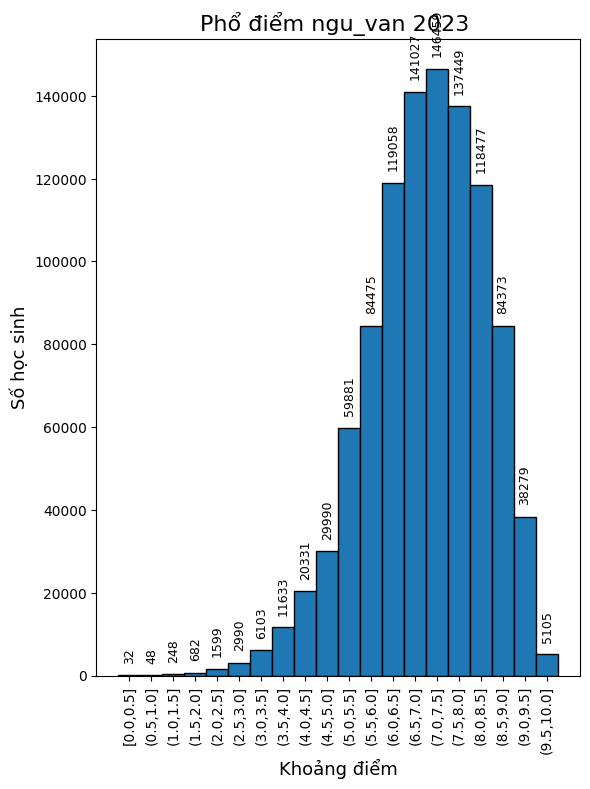

In [37]:
# 1. Mở rộng dữ liệu thô từ Series (index = điểm, values = số lượng)
points = np.repeat(ChoiceSubj_23.index.values, ChoiceSubj_23.values.astype(int))

# 2. Tạo edges để có khoảng: [0,0.5], (0.5,1], ..., (9.5,10]
# hist sẽ hiểu là [a,b) trừ bin cuối, nên mình dịch bin đầu hơi âm
edges = np.concatenate((
    np.array([-1e-6, 0.5]),   # ~ [0,0.5]
    np.arange(1, 10.5, 0.5)   # 1, 1.5, 2, ..., 10
))

# 3. Tạo edges để HIỂN THỊ (không để -1e-6 trong label)
display_edges = edges.copy()
display_edges[0] = 0.0   # hiển thị từ 0

# 4. Tạo label dạng [0,0.5], (0.5,1], ...
labels = []
labels.append(f"[{display_edges[0]},{display_edges[1]}]")   # bin đầu

for i in range(1, len(display_edges) - 1):
    labels.append(f"({display_edges[i]},{display_edges[i+1]}]")

# 5. Tính tần suất theo bins & vẽ BAR
plt.figure(figsize=(6, 8))

# Thay vì plt.hist → dùng np.histogram để tự vẽ bar
n, bin_edges = np.histogram(points, bins=edges)

# Tâm mỗi bin để đặt cột
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
widths = np.diff(bin_edges)

plt.bar(centers, n, width=widths, edgecolor="black")

plt.title(f"Phổ điểm {ChoiceSubj} 2023 ", fontsize=16)
plt.xlabel("Khoảng điểm", fontsize=13)
plt.ylabel("Số học sinh", fontsize=13)

# 6. Set tick theo tâm mỗi bin + label dạng [ ], ( ]
plt.xticks(centers, labels, rotation=90)

# 7. Ghi số lượng lên từng cột (xoay 90°, value nguyên)
for x, count in zip(centers, n):
    if count == 0:
        continue
    y = count
    plt.text(
        x,
        y + max(n) * 0.02,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )

plt.tight_layout()
plt.show()


In [38]:

print(ChoiceSubj_24)


diem
0.00        20.0
0.25        10.0
0.50        11.0
0.75        11.0
1.00         7.0
          ...   
9.00     49253.0
9.25     26758.0
9.50     14197.0
9.75      1843.0
10.00        2.0
Name: 2024, Length: 189, dtype: float64


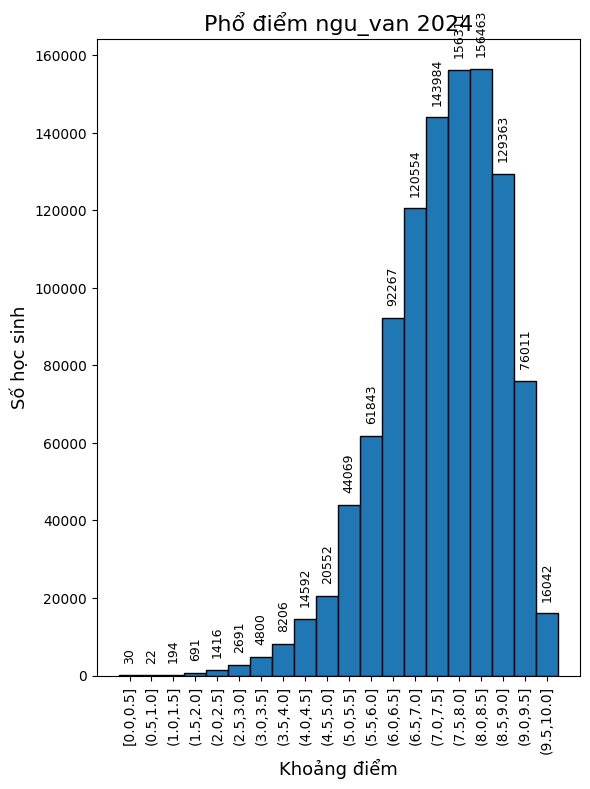

In [39]:
# 1. Mở rộng dữ liệu thô từ Series (index = điểm, values = số lượng)
points = np.repeat(ChoiceSubj_24.index.values, ChoiceSubj_24.values.astype(int))

# 2. Tạo edges để có khoảng: [0,0.5], (0.5,1], ..., (9.5,10]
# hist sẽ hiểu là [a,b) trừ bin cuối, nên mình dịch bin đầu hơi âm
edges = np.concatenate((
    np.array([-1e-6, 0.5]),   # ~ [0,0.5]
    np.arange(1, 10.5, 0.5)   # 1, 1.5, 2, ..., 10
))

# 3. Tạo edges để HIỂN THỊ (không để -1e-6 trong label)
display_edges = edges.copy()
display_edges[0] = 0.0   # hiển thị từ 0

# 4. Tạo label dạng [0,0.5], (0.5,1], ...
labels = []
labels.append(f"[{display_edges[0]},{display_edges[1]}]")   # bin đầu

for i in range(1, len(display_edges) - 1):
    labels.append(f"({display_edges[i]},{display_edges[i+1]}]")

# 5. Tính tần suất theo bins & vẽ BAR
plt.figure(figsize=(6, 8))

# Thay vì plt.hist → dùng np.histogram để tự vẽ bar
n, bin_edges = np.histogram(points, bins=edges)

# Tâm mỗi bin để đặt cột
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
widths = np.diff(bin_edges)

plt.bar(centers, n, width=widths, edgecolor="black")

plt.title(f"Phổ điểm {ChoiceSubj} 2024", fontsize=16)
plt.xlabel("Khoảng điểm", fontsize=13)
plt.ylabel("Số học sinh", fontsize=13)

# 6. Set tick theo tâm mỗi bin + label dạng [ ], ( ]
plt.xticks(centers, labels, rotation=90)

# 7. Ghi số lượng lên từng cột (xoay 90°, value nguyên)
for x, count in zip(centers, n):
    if count == 0:
        continue
    y = count
    plt.text(
        x,
        y + max(n) * 0.02,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )

plt.tight_layout()
plt.show()


In [ ]:
print(ChoiceSubj_25.count)

<bound method Series.count of diem
0.00       10.0
0.25       17.0
0.50       29.0
0.75       43.0
1.00       26.0
         ...   
8.91        1.0
9.00    28391.0
9.25    12004.0
9.50     4104.0
9.75      305.0
Name: 2025, Length: 201, dtype: float64>


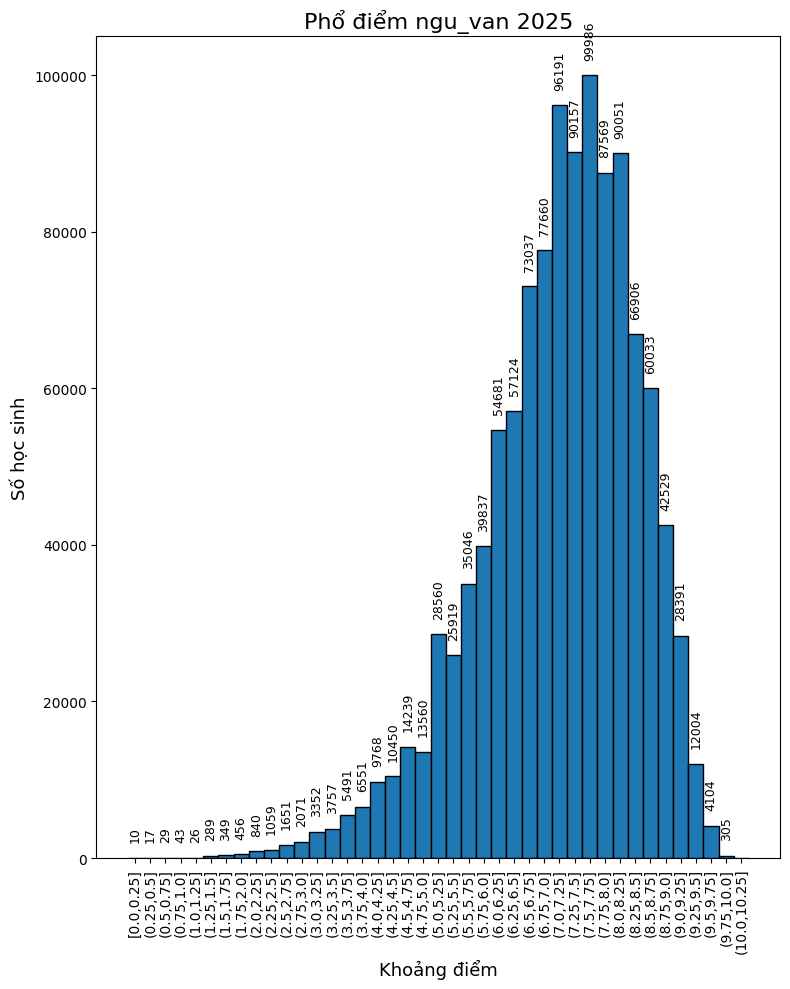

In [44]:
# 1. Mở rộng dữ liệu thô từ Series (index = điểm, values = số lượng)
points = np.repeat(ChoiceSubj_25.index.values, ChoiceSubj_25.values.astype(int))

# 2. Tạo edges để có khoảng: [0,0.5], (0.5,1], ..., (9.5,10]
# hist sẽ hiểu là [a,b) trừ bin cuối, nên mình dịch bin đầu hơi âm
edges = np.concatenate((
    np.array([-1e-6, 0.25]),   # ~ [0,0.5]
    np.arange(0.5, 10.5, 0.25)   # 1, 1.5, 2, ..., 10
))

# 3. Tạo edges để HIỂN THỊ (không để -1e-6 trong label)
display_edges = edges.copy()
display_edges[0] = 0.0   # hiển thị từ 0

# 4. Tạo label dạng [0,0.5], (0.5,1], ...
labels = []
labels.append(f"[{display_edges[0]},{display_edges[1]}]")   # bin đầu

for i in range(1, len(display_edges) - 1):
    labels.append(f"({display_edges[i]},{display_edges[i+1]}]")

# 5. Tính tần suất theo bins & vẽ BAR
plt.figure(figsize=(8, 10))

# Thay vì plt.hist → dùng np.histogram để tự vẽ bar
n, bin_edges = np.histogram(points, bins=edges)

# Tâm mỗi bin để đặt cột
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
widths = np.diff(bin_edges)

plt.bar(centers, n, width=widths, edgecolor="black")

plt.title(f"Phổ điểm {ChoiceSubj} 2025", fontsize=16)   # <-- đổi năm ở đây
plt.xlabel("Khoảng điểm", fontsize=13)
plt.ylabel("Số học sinh", fontsize=13)

# 6. Set tick theo tâm mỗi bin + label dạng [ ], ( ]
plt.xticks(centers, labels, rotation=90)

# 7. Ghi số lượng lên từng cột (xoay 90°, value nguyên)
for x, count in zip(centers, n):
    if count == 0:
        continue
    y = count
    plt.text(
        x,
        y + max(n) * 0.02,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )

plt.tight_layout()
plt.show()


# Theo Tổ Hợp

In [26]:
# Xử lý data theo tổ hợp khối

# Theo Năm 

In [27]:
# Xử lý data qua từng năm